# Fine-tuning Bert with PrivacyQA

In this experiment, we download, tokenize, and train a 🤗 Transformers model on the PrivacyQA question/answering data. This task takes the text of a privacy-related question asked by a user and requires the model to predict whether the sentiment of the review is positive or negative.

# Imports / Dependencies

In [ ]:
# Transformers installation
!pip install transformers
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

!pip install textattack # TextAttack installation (package for text attacks)
!pip install torch==1.6 # need torch 1.6 for the augmenter to work

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import pandas as pd
import numpy as np
from google.colab import drive
import transformers
from transformers import DistilBertTokenizerFast, DistilBertModel, BertConfig, DistilBertPreTrainedModel
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, f1_score, accuracy_score
import pickle
import textattack

making sure torch is 1.6 (need 1.6 for the augmenter otherwise might throw error)

In [ ]:
torch.__version__

'1.6.0'

# Load the Clean Data (no adversarial examples)

Mount google drive

In [ ]:
!rm -rf ./sample_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Read in the PrivacyQA dataset from google drive (assuming you have a shortcut to the 'privacyQA_dataset' directory under 'MyDrive')

In [ ]:
train_set = pd.read_csv('/content/drive/MyDrive/828E_Ophir_Mollie/privacyQA_dataset/train_opp_annotations')
test_set = pd.read_csv('/content/drive/MyDrive/828E_Ophir_Mollie/privacyQA_dataset/test_opp_annotations')
print(train_set.head())
print(test_set.head())

                                 Folder  ... other
0  ../../Dataset/Train/com.cake.browser  ...     0
1  ../../Dataset/Train/com.cake.browser  ...     0
2  ../../Dataset/Train/com.cake.browser  ...     0
3  ../../Dataset/Train/com.cake.browser  ...     0
4  ../../Dataset/Train/com.cake.browser  ...     0

[5 rows x 12 columns]
                                 Folder      DocID  ... audiences unknown
0  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...         0       0
1  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...         0       0
2  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...         0       0
3  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...         0       0
4  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...         0       0

[5 rows x 14 columns]


Drop the unnecessary columns ('audiences' and 'unknown') from the test set.

In [ ]:
test_set = test_set.drop(['audiences', 'unknown'], axis=1)
print(test_set.head())

                                 Folder      DocID  ... user_choice other
0  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...           0     0
1  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...           0     0
2  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...           0     0
3  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...           0     0
4  ../../Dataset/Test/com.fiverr.fiverr  Fiverr _1  ...           0     0

[5 rows x 12 columns]


# Preprocess the Data & Create train-val-test split

Now let's create sets of inputs (query texts) and labels (onehot-encoded) out of the train and test sets.

In [ ]:
def read_pqa_split(dataset):
    """ assumes `dataset` is a pandas DataFrame """
    texts = dataset.Query.to_list()
    label_cols = dataset.columns[5:]
    labels = dataset[label_cols].values.tolist() # onehot-encoded labels
    return texts, labels

train_texts, train_labels = read_pqa_split(train_set)
test_texts, test_labels = read_pqa_split(test_set)

Let's check the class distribution in the training set 

In [ ]:
np.array(train_labels).sum(axis=0)

array([619, 323, 153,  85,  31,  88,  20])

We now have a train and test dataset, but let's also also create a validation set which we can use for evaluation
and tuning without tainting our test set results. Sklearn has a convenient utility for creating such splits:

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2, random_state=42) 

# Augment train_texts with adversarial examples

Load the training 

Create a TextAttack augmenter based on "BAE: BERT-based Adversarial Examples for Text Classification."

In [ ]:
augmenter = textattack.augmentation.recipes.WordNetAugmenter(
    pct_words_to_swap=0.1, 
    transformations_per_example=1
    )

Check that the augmenter works

In [ ]:
s = "will other companies have access to my info?"
augmenter.augment(s)

['will other companies have entree to my info?']

Augment the train set

In [ ]:
print('Size of train_texts before data augmentation', len(train_texts))
train_texts += [augmenter.augment(s)[0] for s in train_texts]
print('Size of train_texts after data augmentation', len(train_texts))

Size of train_texts before data augmentation 1080
Size of train_texts after data augmentation 2160


In [ ]:
print('original example:', train_texts[0])
print('augmented example:', train_texts[0 + 1080])

original example: will my information be shared with anyone?
augmented example: will my information be divided with anyone?


## Tokenization

Alright, we've read in our dataset, created a train-val-test split, and augmented the train set with adversarial examples. Now let's tackle tokenization. We'll eventually train a classifier using
pre-trained DistilBert, so let's use the DistilBert tokenizer.

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('bert-base-uncased')

Now we can simply pass our texts to the tokenizer. We'll pass `truncation=True` and `padding=True`, which will
ensure that all of our sequences are padded to the same length and are truncated to be no longer model's maximum input
length. This will allow us to feed batches of sequences into the model at the same time.

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Now, let's turn our labels and encodings into a Dataset object. In PyTorch, this is done by subclassing a
`torch.utils.data.Dataset` object and implementing `__len__` and `__getitem__`. In TensorFlow, we pass our input
encodings and labels to the `from_tensor_slices` constructor method. We put the data in this format so that the data
can be easily batched such that each key in the batch encoding corresponds to a named parameter of the
`DistilBertForSequenceClassification.forward` method of the model we will train.

In [ ]:
class PqaDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = PqaDataset(train_encodings, train_labels)
val_dataset = PqaDataset(val_encodings, val_labels)
test_dataset = PqaDataset(test_encodings, test_labels)

Now that our datasets our ready, we can fine-tune a model either with the 🤗
`Trainer`. See [training](https://huggingface.co/transformers/training.html).

# Fine-tuning with the `Trainer` module

The steps above prepared the datasets in the way that the trainer is expecting. Now all we need to do is create a model
to fine-tune, define the `TrainingArguments`/`TFTrainingArguments` and
instantiate a `Trainer`/`TFTrainer`.

Importantly, we need to subclass the Trainer class to make it suitable for multilabel classification (by default it is suited for **_multiclass_** classification, which is different and not waht we want here). The extended class was taken from the example at https://huggingface.co/transformers/main_classes/trainer.html#codecell0.

First, we need to subclass and adapt the original DistilBert for multi-label calssification --

In [ ]:
class DistilBertForMultilabelSequenceClassification(DistilBertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.distilbert = DistilBertModel(config)
        self.pre_classifier = torch.nn.Linear(config.dim, config.dim)
        self.classifier = torch.nn.Linear(config.dim, config.num_labels)
        self.dropout = torch.nn.Dropout(config.seq_classif_dropout)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss. Indices should be in :obj:`[0, ...,
            config.num_labels - 1]`. If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        pooled_output = torch.nn.ReLU()(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        logits = self.classifier(pooled_output)  # (bs, num_labels)

        loss = None
        if labels is not None:
            if self.num_labels == 1:
                loss_fct = nn.MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                # the onlny modification to the original DistilBert is below
                loss_fct = torch.nn.BCEWithLogitsLoss()
                loss = loss_fct(logits.view(-1, self.distilbert.config.num_labels),
                                labels.float().view(-1, self.distilbert.config.num_labels))

        if not return_dict:
            output = (logits,) + distilbert_output[1:]
            return ((loss,) + output) if loss is not None else output

        return transformers.modeling_outputs.SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=distilbert_output.hidden_states,
            attentions=distilbert_output.attentions,
        )

In [ ]:
output_dir = '/content/drive/MyDrive/828E_Ophir_Mollie/trained_models/robust_model_300_epochs'

Then, we can instantiate the model and train it --- 

In [ ]:
label_names = ['first', 'third', 'datasecurity', 'dataretention', 'user_access', 'user_choice', 'other']

training_args = TrainingArguments(
    output_dir=output_dir, # output directory for model predictions and checkpoints
    num_train_epochs=300,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_steps=10,
    logging_dir=output_dir+'/logs',
    load_best_model_at_end=True, # will save/checkpoint the model after every evaluation
    evaluation_strategy="epoch", # will evaluate every epoch
    # DO NOT USE # label_names=label_names,  # DO NOT USE THIS --- THROWS ERROR
)

NUM_LABELS = len(label_names)
model = DistilBertForMultilabelSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=NUM_LABELS,
    id2label=dict(enumerate(label_names)), # use to show text labels
    )

# Customized Trainer class for Multi-label classification
class MultilabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.BCEWithLogitsLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                        labels.float().view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

trainer = MultilabelTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
)

# Start the training
trainer.train()
# Save model
model.save_pretrained(output_dir)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForMultilabelSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForMultilabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForMultilabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForMultilabelSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bia

Epoch,Training Loss,Validation Loss
1,0.559800,0.470119
2,0.346000,0.326948
3,0.300800,0.279835
4,0.250200,0.238902
5,0.198100,0.205020
6,0.140900,0.196062
7,0.133500,0.207499
8,0.150100,0.194067
9,0.083400,0.234055
10,0.077500,0.245897


save log

In [ ]:
log = """Epoch	Training Loss	Validation Loss
1	0.559800	0.470119
2	0.346000	0.326948
3	0.300800	0.279835
4	0.250200	0.238902
5	0.198100	0.205020
6	0.140900	0.196062
7	0.133500	0.207499
8	0.150100	0.194067
9	0.083400	0.234055
10	0.077500	0.245897
11	0.072400	0.247015
12	0.062100	0.255925
13	0.065700	0.269246
14	0.053300	0.246676
15	0.056800	0.296060
16	0.036900	0.291808
17	0.039600	0.352154
18	0.048800	0.344852
19	0.043700	0.350342
20	0.046300	0.373862
21	0.030900	0.376217
22	0.029700	0.359710
23	0.030400	0.346916
24	0.027000	0.364793
25	0.027100	0.359272
26	0.026000	0.377986
27	0.021800	0.373140
28	0.029400	0.385679
29	0.032200	0.368443
30	0.022800	0.395905
31	0.022100	0.410789
32	0.026200	0.410080
33	0.025600	0.412345
34	0.015200	0.406654
35	0.021900	0.399077
36	0.021000	0.428026
37	0.021600	0.428881
38	0.021700	0.427863
39	0.025000	0.427087
40	0.024800	0.395224
41	0.014800	0.400683
42	0.021100	0.431196
43	0.019500	0.452779
44	0.016300	0.439628
45	0.029100	0.442375
46	0.028300	0.453882
47	0.035800	0.465385
48	0.021200	0.448949
49	0.025200	0.440874
50	0.013500	0.457453
51	0.020400	0.428763
52	0.033100	0.435032
53	0.013600	0.458121
54	0.015100	0.469808
55	0.011400	0.436006
56	0.018300	0.445149
57	0.017300	0.462114
58	0.014000	0.500280
59	0.023300	0.488038
60	0.020600	0.515321
61	0.032800	0.528564
62	0.022000	0.515918
63	0.022200	0.529855
64	0.018100	0.523812
65	0.022900	0.518398
66	0.019600	0.531369
67	0.021600	0.533020
68	0.025100	0.503675
69	0.023900	0.528367
70	0.031200	0.518869
71	0.031700	0.565235
72	0.030900	0.544844
73	0.013200	0.504516
74	0.025300	0.532274
75	0.025200	0.511878
76	0.026900	0.539361
77	0.015800	0.512244
78	0.016200	0.508902
79	0.021000	0.565429
80	0.019200	0.549894
81	0.015700	0.560344
82	0.020000	0.567573
83	0.020000	0.577297
84	0.027000	0.556123
85	0.041200	0.586313
86	0.016700	0.564840
87	0.023000	0.568245
88	0.014600	0.556611
89	0.024200	0.571457
90	0.015200	0.589862
91	0.013400	0.581497
92	0.018600	0.583226
93	0.031400	0.576166
94	0.028800	0.584310
95	0.027900	0.600843
96	0.022900	0.587267
97	0.020800	0.597962
98	0.022100	0.602012
99	0.019500	0.599918
100	0.023200	0.583493
101	0.024700	0.621706
102	0.034100	0.476762
103	0.033800	0.595104
104	0.016600	0.522541
105	0.021600	0.602599
106	0.020500	0.636281
107	0.033100	0.491710
108	0.014700	0.613411
109	0.027600	0.572729
110	0.020800	0.591923
111	0.024400	0.628333
112	0.012500	0.587408
113	0.013600	0.592991
114	0.022800	0.609854
115	0.015700	0.588186
116	0.021400	0.606900
117	0.017600	0.600876
118	0.019700	0.592427
119	0.022700	0.601038
120	0.019200	0.613581
121	0.032200	0.565460
122	0.016000	0.625876
123	0.016100	0.589825
124	0.021300	0.603347
125	0.018100	0.672239
126	0.011900	0.587757
127	0.024000	0.606122
128	0.017800	0.600261
129	0.023100	0.613062
130	0.014500	0.621775
131	0.015700	0.624678
132	0.022600	0.609336
133	0.028400	0.611929
134	0.022600	0.618793
135	0.016000	0.615707
136	0.009200	0.611771
137	0.013100	0.613866
138	0.016300	0.620070
139	0.010700	0.619868
140	0.030800	0.589839
141	0.027400	0.589592
142	0.018200	0.593527
143	0.026400	0.592529
144	0.012700	0.608317
145	0.014600	0.591075
146	0.011400	0.608273
147	0.020100	0.611581
148	0.014100	0.659040
149	0.022700	0.612128
150	0.020000	0.655395
151	0.025700	0.633563
152	0.015800	0.641893
153	0.018700	0.593302
154	0.013400	0.644582
155	0.025700	0.623631
156	0.011300	0.625497
157	0.021000	0.620496
158	0.017700	0.626953
159	0.016500	0.631653
160	0.018500	0.635136
161	0.022400	0.636953
162	0.018100	0.661753
163	0.020100	0.648165
164	0.013800	0.638569
165	0.016900	0.703062
166	0.023000	0.610407
167	0.022800	0.648651
168	0.018800	0.699240
169	0.021300	0.687020
170	0.015100	0.636446
171	0.017900	0.655840
172	0.021800	0.647029
173	0.022400	0.650743
174	0.017300	0.660656
175	0.016700	0.656666
176	0.019200	0.666873
177	0.013600	0.664324
178	0.018000	0.665968
179	0.016100	0.670681
180	0.019100	0.661790
181	0.020500	0.670044
182	0.021900	0.672569
183	0.015400	0.676436
184	0.016200	0.683198
185	0.021700	0.704204
186	0.018900	0.685452
187	0.013600	0.670718
188	0.026800	0.676811
189	0.021800	0.721477
190	0.032400	0.662773
191	0.012300	0.682285
192	0.018200	0.691982
193	0.017000	0.683969
194	0.020800	0.685986
195	0.014500	0.693515
196	0.016800	0.664596
197	0.013800	0.668860
198	0.021400	0.666628
199	0.020100	0.664937
200	0.020200	0.669071
201	0.013300	0.666425
202	0.022000	0.671987
203	0.014000	0.676774
204	0.028900	0.679125
205	0.014200	0.682479
206	0.017300	0.685094
207	0.020400	0.677392
208	0.013500	0.683524
209	0.016200	0.682939
210	0.014700	0.684681
211	0.012900	0.690769
212	0.025600	0.694612
213	0.016900	0.691463
214	0.027900	0.691056
215	0.023800	0.693491
216	0.017500	0.694685
217	0.017800	0.704734
218	0.017300	0.701109
219	0.016700	0.707562
220	0.013700	0.703809
221	0.020000	0.704000
222	0.017000	0.714046
223	0.017200	0.713677
224	0.019200	0.713903
225	0.011800	0.717068
226	0.025400	0.721918
227	0.018600	0.719541
228	0.018900	0.722517
229	0.017500	0.722293
230	0.015300	0.712054
231	0.016800	0.707417
232	0.022600	0.711027
233	0.018800	0.714471
234	0.013100	0.715202
235	0.016600	0.720376
236	0.020300	0.724859
237	0.023800	0.728684
238	0.020000	0.725111
239	0.016200	0.722019
240	0.026600	0.721485
241	0.017000	0.724365
242	0.018200	0.723561
243	0.019900	0.724070
244	0.018600	0.727612
245	0.015200	0.727690
246	0.019400	0.727216
247	0.021800	0.727195
248	0.014900	0.726272
249	0.020700	0.723608
250	0.018600	0.725576
251	0.021500	0.728760
252	0.017100	0.731393
253	0.017700	0.739669
254	0.025100	0.734015
255	0.017000	0.737539
256	0.014600	0.731299
257	0.017200	0.730446
258	0.015100	0.734010
259	0.008400	0.710844
260	0.020600	0.726681
261	0.017900	0.731052
262	0.017800	0.731842
263	0.013000	0.733300
264	0.009000	0.735122
265	0.011700	0.735806
266	0.015600	0.736436
267	0.016200	0.732931
268	0.019900	0.736397
269	0.017700	0.735828
270	0.012700	0.741268
271	0.024100	0.739315
272	0.015300	0.741624
273	0.015200	0.736784
274	0.023500	0.741658
275	0.016400	0.743376
276	0.016000	0.746505
277	0.014900	0.745498
278	0.018400	0.747289
279	0.016000	0.741611
280	0.017100	0.743517
281	0.020500	0.740550
282	0.016200	0.740710
283	0.018000	0.737443
284	0.019500	0.733460
285	0.007700	0.736230
286	0.015900	0.736416
287	0.020900	0.739683
288	0.013700	0.742085
289	0.020300	0.747975
290	0.014400	0.749665
291	0.012900	0.749360
292	0.020200	0.750037
293	0.012000	0.749725
294	0.012400	0.749680
295	0.019600	0.750740
296	0.023600	0.751120
297	0.018100	0.751067
298	0.022100	0.750784
299	0.023900	0.750804
300	0.012000	0.750818
"""
with open(output_dir+'/train_history_log', 'w') as f:
    f.write(log)

# Plotting Training history

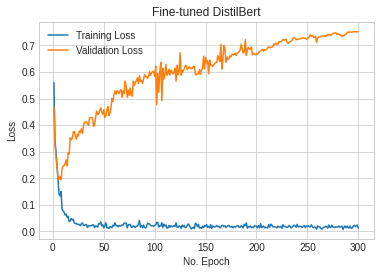

In [ ]:
history = pd.read_csv(output_dir+'/train_history_log',sep='\t')

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(6,4))
plt.plot(history['Epoch'], history['Training Loss'], label='Training Loss')
plt.plot(history['Epoch'], history['Validation Loss'], label='Validation Loss')
plt.xlabel("No. Epoch")
plt.ylabel("Loss")
plt.title("Fine-tuned DistilBert")
plt.legend()
plt.savefig(output_dir+'/train_history_plot.png', dpi=300)
plt.show()

# Evaluation

Let's load up the trained model (if not already loaded)

In [ ]:
label_names = ['first', 'third', 'datasecurity', 'dataretention',
                           'user_access', 'user_choice', 'other']
NUM_LABELS = len(label_names)
# Loading the checkpoint with the best validation loss (checkpoint-408)
path_to_model_dir = output_dir
model = DistilBertForMultilabelSequenceClassification.from_pretrained(
    path_to_model_dir, 
    num_labels=NUM_LABELS,
    id2label=dict(enumerate(label_names)), # use to show text labels
)

Set it to evaluation mode --

In [ ]:
model.eval()

DistilBertForMultilabelSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=Fals

## Qualitative Evaluation (Simple Predictions for Text Queries)

In [ ]:
# Convert token to vocabulary indices
some_queries = ["what information do you collect?",  # label: 'first'
                "are you certified to be secure?",   # label: 'datasecurity'
                "who can read the chat i have with the platform?",   # labels: ['first',	'third']
                ]

def predict_labels(model, query):
    labels = np.array(['first', 'third', 'datasecurity', 'dataretention',
                           'user_access', 'user_choice', 'other'])
    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor(tokenizer([query], truncation=True, padding=True)['input_ids'])
    model.eval()
    tokens_tensor.to('cpu')
    model.to('cpu')
    probabilities = torch.sigmoid(model(tokens_tensor)[0][0])
    bool_pred = np.array([True if p > 0.5 else False for p in probabilities])
    label_pred = labels[bool_pred].tolist()
    return label_pred

for query in some_queries:
    print(predict_labels(model, query))

['first']
['datasecurity']
['first', 'third']


Let's check for consistency/robustness --

In [ ]:
print(predict_labels(model, "will other companies have access to my info?"))
print(predict_labels(model, "will other companies have access to my information?"))
print(predict_labels(model, "will other companies have access to my information?"))
print(predict_labels(model, "will other entities see my data?"))
print(predict_labels(model, "will other entities see my info?"))
print(predict_labels(model, "will other companies see my data?"))
print()
print(predict_labels(model, "will you allow me to remove data?"))
print(predict_labels(model, "will you let me remove stuff?"))
print(predict_labels(model, "will you let me remove everything?"))
print()
print(predict_labels(model, "could I delete my data?"))
print(predict_labels(model, "will I be able to delete my information?"))
print()
print(predict_labels(model, "will you keep my information forever?"))
print(predict_labels(model, "What will you do to my information?"))
print(predict_labels(model, "What will you do to my data?"))

['first', 'third']
['first', 'third']
['first', 'third']
['third']
['third']
['first', 'third']

['user_choice']
['user_choice']
['user_choice']

['user_access']
['user_access']

['dataretention']
['first', 'third']
['first', 'third']


We can see that small changes to the input will sometimes affect the model's output. We wanna see if we can make the model more robust to these changes by adding adversarial examples to the data.

## Quantitative Evaluation

Let's do a quick check to see that the model is indeed the one that performed best on the validation set (i.e. a loss of ~0.2) --

In [ ]:
evaluator = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    eval_dataset=val_dataset,             # evaluation dataset
)

eval_results = evaluator.evaluate()
print()
for key in ['eval_loss']:
    value = eval_results[key]
    if type(value) != type(np.array([])):
        print(f'{key}:', value)
    else:
        print(f'{key}:\n')
        for lab, val in zip(label_names, value): 
            print(f'{lab}:', val)
    print()


eval_loss: 0.09499890357255936



Get the predictions and ground truths --

In [ ]:
model.to('cpu')

# produce one-hot preds 
y_true = val_dataset[:]['labels'].tolist()
y_pred = #torch.sigmoid(model(val_dataset[:]['input_ids'])[0]).round().detach().numpy().astype('int32').tolist()

## Confusion Matrix

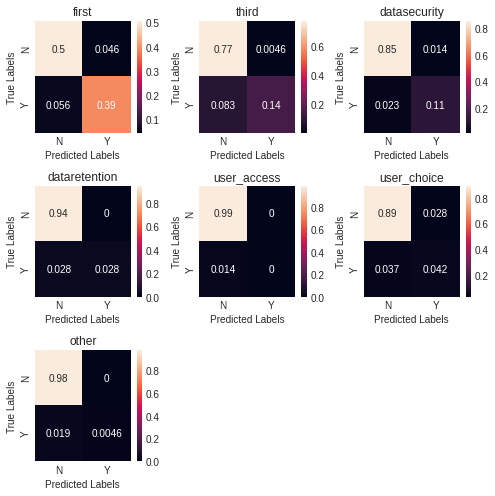

In [ ]:
label_names = ['first', 'third', 'datasecurity', 'dataretention',
                           'user_access', 'user_choice', 'other']
con_mat = multilabel_confusion_matrix(y_true, y_pred) / len(y_true)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(7,7))
for i, ax in enumerate(axes.flat):
    if i < 7:
        con_mat_df = pd.DataFrame(con_mat[i], index=['N', 'Y'], columns=['N', 'Y'])    
        sns.heatmap(con_mat_df, annot=True, ax=ax)
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_title(label_names[i])
    else:
        ax.set_visible(False)

plt.tight_layout() 
plt.savefig(output_dir+'/confusion_matrices.png', dpi=300)
plt.show()

## Evaluate the model with the following metrics: accuracy, F1 score, precision, and recall.

In [ ]:
label_names = ['first', 'third', 'datasecurity', 'dataretention', 'user_access', 'user_choice', 'other']
# Print and save classification report
print('Validation F1 Accuracy: ', f1_score(y_true, y_pred,average='micro'))
print('Validation Flat Accuracy: ', accuracy_score(y_true, y_pred),'\n')
clf_report = classification_report(y_true, y_pred, target_names=label_names)
pickle.dump(clf_report, open(output_dir+'/classification_report.txt','wb')) #save report
print(clf_report)

Validation F1 Accuracy:  0.8041237113402062
Validation Flat Accuracy:  0.6944444444444444 

               precision    recall  f1-score   support

        first       0.89      0.88      0.89        97
        third       0.97      0.63      0.77        49
 datasecurity       0.89      0.83      0.86        29
dataretention       1.00      0.50      0.67        12
  user_access       0.00      0.00      0.00         3
  user_choice       0.60      0.53      0.56        17
        other       1.00      0.20      0.33         5

    micro avg       0.89      0.74      0.80       212
    macro avg       0.76      0.51      0.58       212
 weighted avg       0.88      0.74      0.79       212
  samples avg       0.67      0.64      0.64       212



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
